In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import json 
import random as rd

The approach of Bertsimas and Periakis to dynamic pricing consists of three steps.
- Demand estimation
- Estimation of the competitor's price
- (Myopic) own price setting

The demand model is
$$
d_{k,t} = \beta^{0}_{k,t} +  \beta^{1}_{k,t} p_{1,t} +  \beta^{2}_{k,t} p_{2,t} + \epsilon_{k,t}
$$
where $k=1$ refers to you and $k=2$ refers to your competitor.

The input to the demand model is
- your own prices up to sales period t-1
- the quantity of demand you sold at you price levelt up to period t-1
- your competitor's prices up to sales period t-1

We want to minimize the deviation from the observed values to the estimated values given the demand model.

$$ 
\min \sum\limits_{\tau = 1}^{t-1} \left|d_{1,\tau} - \left( \hat{\beta}^{0}_{1,\tau} +  \hat{\beta}^{1}_{1,\tau} p_{1,\tau} +  \hat{\beta}^{2}_{1,\tau} p_{2,\tau} \right) \right| 
$$
such that $|\hat{\beta}^i_{1,\tau} - \hat{\beta}^i_{1,\tau+1}| \le \delta_1(i)$ for $i = 0, 1, 2$ and $\tau = 1, \ldots, t-2$

This nonlinear optimization problem can be linearized as follows:

$$ \min \sum\limits_{\tau = 1}^{t-1} \Delta_{\tau} $$
such that 
$
\Delta_{\tau} \ge \left|d_{1,\tau} - \left( \hat{\beta}^{0}_{1,\tau} +  \hat{\beta}^{1}_{1,\tau} p_{1,\tau} +  \hat{\beta}^{2}_{1,\tau} p_{2,\tau} \right) \right|
$ for all $\tau = 1, \ldots, t-1$ 
and
$|\hat{\beta}^i_{1,\tau} - \hat{\beta}^i_{1,\tau+1}| \le \delta_1(i)$ for $i = 0, 1, 2$ and $\tau = 1, \ldots, t-2$

The first constraint can be linearized by considering the positive and negative part of the absolute value:

$$ 
\Delta_{\tau} \ge d_{1,\tau} - \left( \hat{\beta}^{0}_{1,\tau} +  \hat{\beta}^{1}_{1,\tau} p_{1,\tau} +  \hat{\beta}^{2}_{1,\tau} p_{2,\tau} \right)
$$ and
$$ 
\Delta_{\tau} \ge -d_{1,\tau} + \left( \hat{\beta}^{0}_{1,\tau} +  \hat{\beta}^{1}_{1,\tau} p_{1,\tau} +  \hat{\beta}^{2}_{1,\tau} p_{2,\tau} \right)
$$

The same holds for the second constraint, i.e.
$$
\hat{\beta}^i_{1,\tau} - \hat{\beta}^i_{1,\tau+1} \le \delta_1(i)
$$ 
and
$$
-\hat{\beta}^i_{1,\tau} + \hat{\beta}^i_{1,\tau+1}| \le \delta_1(i)
$$

# Load data

### Load data from one competition

In [2]:
df = pd.read_csv("../../Results/11.24/duopoly_competition_details.csv")
df = df[(df['selling_season'] == df['selling_season'][0]) & (df['competition_id'] == df['competition_id'][0])]
X = df[[ 'price','price_competitor']]
y = df[['demand']] 

X = X.to_numpy()
y = np.asarray(y).reshape(-1)
# plt.plot(X[0:], y)
print(X, y)

[[31.2 74.8]
 [29.6 14. ]
 [28.1 60. ]
 [26.7 31.7]
 [45.1 73. ]
 [42.8 86.6]
 [40.7 80. ]
 [38.7 27.9]
 [36.7  8.1]
 [55.1  0.7]
 [52.4 65. ]
 [49.8 15.5]
 [47.3 53. ]
 [44.9 40.6]
 [35.  49.3]
 [33.2 28.9]
 [31.6 35.7]
 [30.  96.5]
 [28.5 61.8]
 [54.5 93.2]
 [51.7 29.5]
 [49.1  7.8]
 [46.7 18.7]
 [44.4 66.2]
 [43.1 49.6]
 [40.9 45.8]
 [38.9 64.8]
 [36.9 54.8]
 [35.1 92.3]
 [61.4 77.9]
 [58.4 90.3]
 [55.4 17. ]
 [52.7 70.4]
 [50.  28.1]
 [56.7 23.4]
 [53.9 16.6]
 [51.2 31.1]
 [48.6 41.5]
 [46.2 38.7]
 [30.3 69.5]
 [28.8 25.5]
 [27.3 66.6]
 [26.   0.4]
 [24.7 24.4]
 [37.3 22.4]
 [35.4 27.2]
 [33.6 40.4]
 [32.  40.5]
 [30.4 67.8]
 [39.7 82.4]
 [37.7 53.5]
 [35.8 72.5]
 [34.  92.6]
 [32.3 23.6]
 [64.9 72.8]
 [61.7 50.4]
 [58.6 46.7]
 [55.7 18.5]
 [52.9 32.5]
 [44.2 98.6]
 [42.   7.3]
 [39.9 40.7]
 [37.9 76.1]
 [36.  77. ]
 [59.9  4.8]
 [56.9 61.3]
 [54.1 79.9]
 [51.4 54.8]
 [48.8 71.5]
 [54.5 44. ]
 [51.8 33.6]
 [49.2 66.9]
 [46.7 35.5]
 [44.4 48.1]
 [45.6 99.2]
 [43.3 26.4]
 [41.2 53.8]

### Load data from all competition

On doit parcourir tout le fichier ../../Results/ en extraire chaque date. Dans chaque de ces fichiers on trouvera un `duopoly_competition_details.csv`, que l'on extrairera. Pour garder cela cohérent, on conservera la colonne competition. 

In [3]:
all_df = pd.DataFrame()
back_path = "../../Results"
following_path = "duopoly_competition_details.csv"
for folder in os.listdir(back_path):
    df_path = back_path + '/' + folder + '/' + following_path
    df = pd.read_csv(df_path)
    all_df = pd.concat([all_df, df[['demand','price','price_competitor','competition_id']]])

# print(all_df['competition_id'].nunique())

print(all_df[all_df['demand'] == all_df['demand'].max()])
all_df


       demand  price  price_competitor competition_id
10743      10   24.6              31.4         HTmLPU


,demand,price,price_competitor,competition_id
0,0,150.0,30.0,35gvEP
1,0,150.0,80.0,35gvEP
2,0,150.0,40.0,35gvEP
3,0,150.0,90.0,35gvEP
4,0,150.0,89.7,35gvEP
...,...,...,...,...
29995,0,20.0,4.4,fw6wpA
29996,0,20.0,2.6,fw6wpA
29997,0,20.0,1.3,fw6wpA
29998,0,20.0,0.5,fw6wpA


# Regression 

## On one competition

### OLS

In [4]:
solver = 'ipopt'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

In [5]:
def ols_regression(X, y):
    m = pyo.ConcreteModel("OLS Regression")

    n, k = X.shape

    # note use of Python style zero based indexing
    m.I = pyo.RangeSet(0, n - 1)
    m.J = pyo.RangeSet(0, k - 1)

    m.e = pyo.Var(m.I, domain=pyo.Reals)
    m.m = pyo.Var(m.J)
    m.b = pyo.Var()

    @m.Constraint(m.I)
    def residuals(m, i):
        return m.e[i] == y[i] - sum(X[i][j] * m.m[j] for j in m.J) - m.b

    @m.Objective(sense=pyo.minimize)
    def sum_of_square_errors(m):
        return sum((m.e[i]) ** 2 for i in m.I)

    return m


m = ols_regression(X, y)
SOLVER.solve(m)
m.m.display()
m.b.display()


m : Size=2, Index=J
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :  None : -0.017455268055988963 :  None : False : False :  Reals
      1 :  None :  0.004841880918439343 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 0.7128910769609748 :  None : False : False :  Reals


In [6]:
def compute_regression_metrics(X, y, coef, intercept):
    # Prédictions
    y_pred = X @ coef + intercept
    
    # Résidus
    residuals = y - y_pred
    
    # Métriques standard
    n = len(y)
    p = X.shape[1]

    SSE = np.sum((y - y_pred)**2)
    SST = np.sum((y - np.mean(y))**2)
    SSR = SST - SSE

    R2 = 1 - SSE / SST
    R2_adj = 1 - (SSE/(n - p - 1)) / (SST/(n - 1))

    MSE = SSE / n
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.abs(residuals))

    return {
        "R2": R2,
        "R2_adj": R2_adj,
        "SSE": SSE,
        "SSR": SSR,
        "SST": SST,
        "MSE": MSE,
        "RMSE": RMSE,
        "MAE": MAE,
        "residuals": residuals,
        "y_pred": y_pred
    }


## One all competition

Pour chaque competition, on va faire une regression linéaire. On la sauvegarde dans un dictionnaire

In [7]:
import tqdm

reg_lin_results = {}
for comp in tqdm.tqdm(all_df['competition_id'].unique()): 
    X = all_df[all_df['competition_id'] == comp][['price', 'price_competitor']]
    y = all_df[all_df['competition_id'] == comp][['demand']]
    X = X.to_numpy()
    y = np.asarray(y).reshape(-1)
    if sum(y) < 20 :
        print(f"On {comp} competition, we did'nt sale any shit")
        continue

    m = ols_regression(X, y)
    SOLVER.solve(m)
    coef = np.array([m.m[k].value for k in m.m])
    intercept = m.b.value

    metrics = compute_regression_metrics(X, y, coef, intercept)
    reg_lin_results[comp] = {
        "coeff": [float(m.m[k].value) for k in m.m],
        "intercept": float(m.b.value),
        "R2" : metrics['R2'],
        "MSE": metrics['MSE']
    }

dict_folder = './LinReg_results'
os.makedirs(dict_folder, exist_ok = True)
with open(os.path.join(dict_folder, 'dict'), 'w') as f:
    json.dump(reg_lin_results, f)

  0%|          | 0/66 [00:00<?, ?it/s]

On 35gvEP competition, we did'nt sale any shit


  3%|▎         | 2/66 [00:00<00:06, 10.26it/s]

On 3dncK4 competition, we did'nt sale any shit
On 4AnUch competition, we did'nt sale any shit
On 4PKfqE competition, we did'nt sale any shit


  6%|▌         | 4/66 [00:00<00:04, 12.42it/s]

On 4SZJPv competition, we did'nt sale any shit


 12%|█▏        | 8/66 [00:02<00:21,  2.67it/s]

On 3FraHT competition, we did'nt sale any shit
On 3gG43f competition, we did'nt sale any shit


 18%|█▊        | 12/66 [00:05<00:24,  2.19it/s]

On 37MW64 competition, we did'nt sale any shit
On 3JJsMh competition, we did'nt sale any shit
On hmSc7x competition, we did'nt sale any shit


 21%|██        | 14/66 [00:05<00:17,  3.03it/s]

On 34FWTM competition, we did'nt sale any shit
On 3SLntX competition, we did'nt sale any shit


 24%|██▍       | 16/66 [00:07<00:28,  1.76it/s]

On 4R8bN7 competition, we did'nt sale any shit
On 32gZbC competition, we did'nt sale any shit


 50%|█████     | 33/66 [00:37<00:52,  1.58s/it]

On ejFyn5 competition, we did'nt sale any shit


 68%|██████▊   | 45/66 [00:58<00:39,  1.90s/it]

On 4NPzQG competition, we did'nt sale any shit


 71%|███████   | 47/66 [01:00<00:26,  1.41s/it]

On XsTzYu competition, we did'nt sale any shit


 80%|████████  | 53/66 [01:06<00:12,  1.00it/s]

On 4J3FMm competition, we did'nt sale any shit
On 39vTA9 competition, we did'nt sale any shit


 88%|████████▊ | 58/66 [01:15<00:12,  1.62s/it]

On 4KZ4uk competition, we did'nt sale any shit


100%|██████████| 66/66 [01:27<00:00,  1.33s/it]


Now I have a dictionnary with a linear regression on all my competition where I sold more than 20 items. 

Now I want to predict the demand from my competitor. Today, we will just take the last price. Then, with this equation of the demanding model: 
$$
d_{k,t} = \beta^{0}_{k,t} +  \beta^{1}_{k,t} p_{1,t} +  \beta^{2}_{k,t} p_{2,t} + \epsilon_{k,t}
$$
where $k=1$ refers to you and $k=2$ refers to your competitor.

It means that our price is : 
$$
p_{1,t} = \frac{1}{\beta^{1}_{k,t}}
\left( d_{k,t} - \beta^{0}_{k,t} - \beta^{2}_{k,t} p_{2,t} - \epsilon_{k,t} \right).
$$

We are able to compute our own price.

In [8]:
def set_our_price(d, intercept, coeff, last_price_competitor) : 
    return 1/coeff[0] * (d - intercept - last_price_competitor*coeff[1])

We can try it on a single season and see.

In [9]:
with open('LinReg_results/dict') as f:
    dict_linreg = json.load(f) 

rd.seed(42)
competition_observed = rd.choice(list(dict_linreg.keys()))
print(competition_observed)

coeff     = dict_linreg[competition_observed]['coeff']
intercept = dict_linreg[competition_observed]['intercept']
print(coeff, intercept)

3cuFyA
[-0.013864887637616953, 0.013520663949032065] 0.2973779827744229


# Try to make 3 demand type, high, low and medium

In [10]:
# I want to plot the demand curve giving a competitor price fixed at 25 for all my demand model
with open('LinReg_results/dict') as f:
    dict_linreg = json.load(f) 
competitor_price = 25
price = np.linspace(0, 100, 200)
demand_curves_df = pd.DataFrame(columns=['price', 'demand', 'competition_id'])

# Itérer sur les IDs de compétition (clés) et leurs données de régression (valeurs)
# On utilise dict_linreg.items() pour obtenir à la fois la clé et la valeur
for comp_id, linreg_data in dict_linreg.items():
    # Correction: comp_id est la clé (ex: 'DJzqdu'), linreg_data est la valeur (le dictionnaire des résultats)
    
    # Extraire les coefficients et l'interception
    # coeff[0] correspond au coefficient de 'price'
    # coeff[1] correspond au coefficient de 'price_competitor'
    coeff = linreg_data['coeff']
    intercept = linreg_data['intercept']
    
    # Calculer la valeur de la demande pour chaque point du PRICE_RANGE (price)
    # L'équation de la demande est: Demand = Intercept + Coeff_price * Price + Coeff_competitor * COMPETITOR_PRICE_FIXED
    demand_value = intercept + coeff[0] * price + coeff[1] * competitor_price
    if demand_value.min() < 0:
        demand_value = np.maximum(demand_value, 0)

    # Créer un DataFrame temporaire
    demand_temp = pd.DataFrame({
        'price': price, 
        'demand': demand_value, 
        # Correction: assigner directement l'ID de la compétition
        'competition_id': comp_id 
    })
    
    # Ajouter le DataFrame temporaire au DataFrame principal
    demand_curves_df = pd.concat([demand_curves_df, demand_temp], ignore_index=True)

print("Aperçu du DataFrame final des courbes de demande:")
print(demand_curves_df)

Aperçu du DataFrame final des courbes de demande:
           price    demand competition_id
0       0.000000  1.217313         DJzqdu
1       0.502513  1.213221         DJzqdu
2       1.005025  1.209129         DJzqdu
3       1.507538  1.205037         DJzqdu
4       2.010050  1.200944         DJzqdu
...          ...       ...            ...
9195   97.989950  0.000000         fw6wpA
9196   98.492462  0.000000         fw6wpA
9197   98.994975  0.000000         fw6wpA
9198   99.497487  0.000000         fw6wpA
9199  100.000000  0.000000         fw6wpA

[9200 rows x 3 columns]


C:\Users\yannl\AppData\Local\Temp\ipykernel_30236\625350221.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  demand_curves_df = pd.concat([demand_curves_df, demand_temp], ignore_index=True)


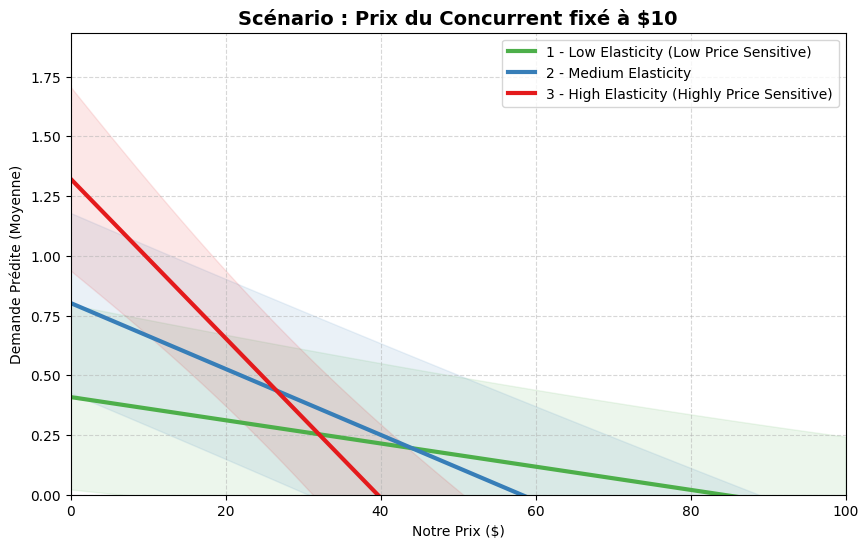

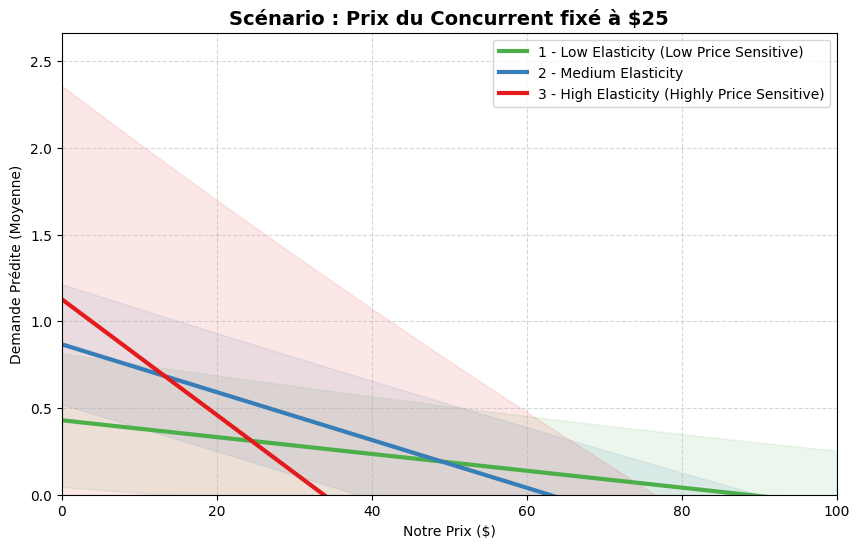

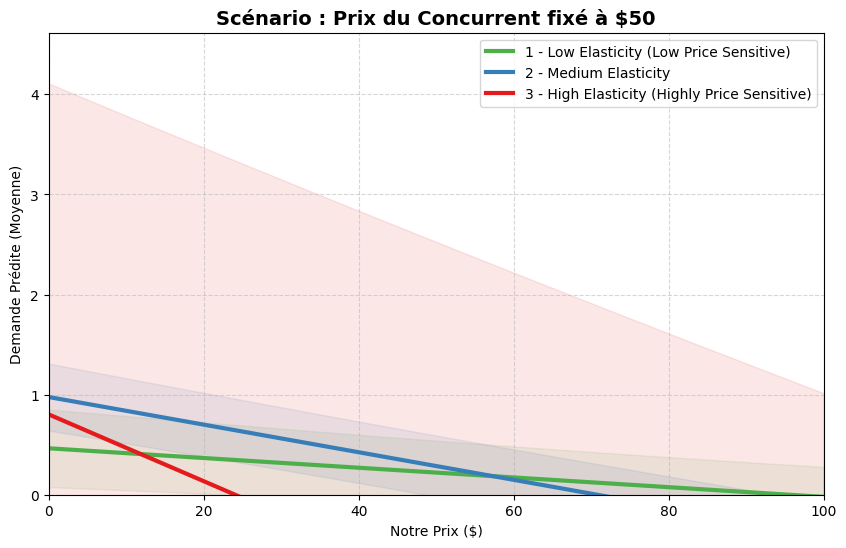

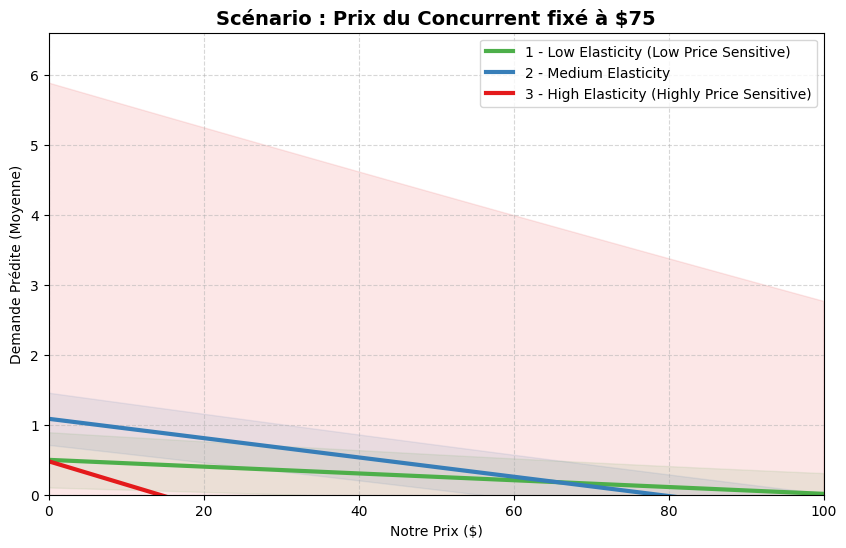

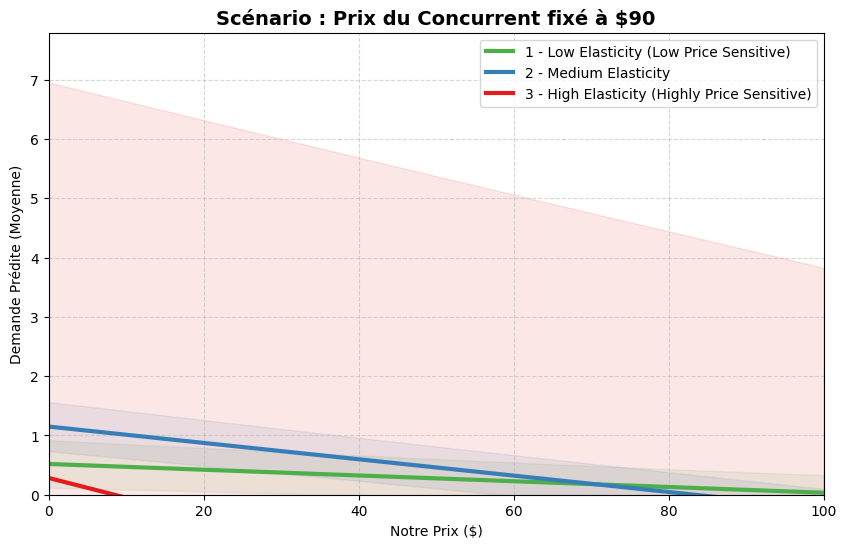


--- Calcul et Sauvegarde des Modèles Moyens ---
                               elasticity_group  intercept  coeff_price  \
0      1 - Low Elasticity (Low Price Sensitive)   0.395006    -0.004855   
1                         2 - Medium Elasticity   0.758985    -0.013792   
2  3 - High Elasticity (Highly Price Sensitive)   1.452583    -0.033366   

   coeff_competitor  count  
0          0.001378     14  
1          0.004343     13  
2         -0.012996     13  

Succès ! Les 3 modèles moyens ont été sauvegardés dans : modeles_moyens_elasticite.csv


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

with open('LinReg_results/dict') as f:
    dict_linreg = json.load(f) 
competitor_price = [10, 25, 50, 75, 90]
price = np.linspace(0, 100, 200)
demand_curves_df = pd.DataFrame(columns=['price', 'demand', 'competition_id'])

data = []
for comp_id, res in dict_linreg.items():
    data.append({
        'comp_id': comp_id,
        'coeff_price': res['coeff'][0],      # Coefficient for the product's price
        'coeff_competitor': res['coeff'][1], # Coefficient for the competitor's price
        'intercept': res['intercept'],
        'R2': res['R2']
    })
df_models = pd.DataFrame(data)

def classify_elasticity(coeff):
    # 1. D'abord, on vérifie les valeurs EXTRÊMEMENT négatives (le tiers le plus bas)
    # Utilisez Q_low_limit (le quantile 0.33, ex: -0.03)
    if coeff < Q_low_limit:
        return '3 - High Elasticity (Highly Price Sensitive)'
        
    # 2. Ensuite, on vérifie ce qui reste en dessous du seuil haut
    # (ce seront les valeurs entre Q_low et Q_high, ex: entre -0.03 et -0.01)
    elif coeff < Q_high_limit:
        return '2 - Medium Elasticity'
        
    # 3. Enfin, le reste des valeurs négatives (proches de 0)
    elif coeff < 0:
        return '1 - Low Elasticity (Low Price Sensitive)'
        
    # 4. Les valeurs positives
    else:
        return '0 - Positive Price Effect (Anomaly)'
# ==============================================================================
# 1. CALCUL DES QUANTILES & CLASSIFICATION
# ==============================================================================

# On isole les coefficients négatifs pour définir les seuils
negative_coeffs = df_models[df_models['coeff_price'] < 0]['coeff_price']
Q_low_limit = negative_coeffs.quantile(0.33)
Q_high_limit = negative_coeffs.quantile(0.66)

# Application de votre fonction de classification (la version corrigée)
df_models['elasticity_group'] = df_models['coeff_price'].apply(classify_elasticity)

# On retire le groupe "Anomaly" pour les graphiques
df_clean = df_models[df_models['elasticity_group'] != '0 - Positive Price Effect (Anomaly)'].copy()
df_clean.sort_values('elasticity_group', inplace=True)

# ==============================================================================
# 2. GÉNÉRATION DES 5 PLOTS (BOUCLE SUR COMPETITOR_PRICE)
# ==============================================================================

# Couleurs pour les 3 groupes
colors = {
    '3 - High Elasticity (Highly Price Sensitive)': '#e41a1c', # Rouge
    '2 - Medium Elasticity': '#377eb8',                       # Bleu
    '1 - Low Elasticity (Low Price Sensitive)': '#4daf4a'     # Vert
}

# La liste que vous avez fournie
competitor_price_list = [10, 25, 50, 75, 90] 
price_range = np.linspace(0, 100, 200) # Votre range de prix X

# BOUCLE PRINCIPALE : Un graphique pour chaque prix concurrent
for comp_p in competitor_price_list:
    
    plt.figure(figsize=(10, 6))
    
    # Pour chaque groupe d'élasticité (Low, Medium, High)
    for group_name, group_df in df_clean.groupby('elasticity_group'):
        
        # A. Récupérer les coefficients moyens du groupe
        mean_intercept = group_df['intercept'].mean()
        mean_coeff_price = group_df['coeff_price'].mean()
        mean_coeff_competitor = group_df['coeff_competitor'].mean()
        
        # B. Calculer la courbe MOYENNE
        # Notez l'utilisation de 'comp_p' (le prix concurrent de la boucle actuelle)
        demand_mean = mean_intercept + (mean_coeff_price * price_range) + (mean_coeff_competitor * comp_p)
        
        # C. Tracer la ligne moyenne
        plt.plot(
            price_range, 
            demand_mean, 
            color=colors.get(group_name, 'gray'), 
            linewidth=3, 
            label=f"{group_name}"
        )
        
        # D. (Optionnel) Ajouter la zone d'écart-type (Ombrage)
        # On recalcule la demande pour chaque compétition individuelle avec ce prix concurrent spécifique
        all_demands = []
        for _, row in group_df.iterrows():
            d = row['intercept'] + (row['coeff_price'] * price_range) + (row['coeff_competitor'] * comp_p)
            all_demands.append(d)
        
        # Calcul de l'écart-type
        std_demand = np.array(all_demands).std(axis=0)
        
        plt.fill_between(
            price_range, 
            demand_mean - std_demand, 
            demand_mean + std_demand, 
            color=colors.get(group_name, 'gray'), 
            alpha=0.1
        )

    # Mise en forme du graphique actuel
    plt.title(f"Scénario : Prix du Concurrent fixé à ${comp_p}", fontsize=14, fontweight='bold')
    plt.xlabel("Notre Prix ($)")
    plt.ylabel("Demande Prédite (Moyenne)")
    plt.ylim(bottom=0) # On coupe les demandes négatives
    plt.xlim(0, 100)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Affichage immédiat du plot avant de passer au suivant dans la boucle
    plt.show()

# ==============================================================================
# 3. SAUVEGARDE DES MODÈLES MOYENS (EXPORT CSV)
# ==============================================================================

print("\n--- Calcul et Sauvegarde des Modèles Moyens ---")

# 1. Grouper par catégorie d'élasticité et calculer la moyenne des coefficients
# On utilise df_clean qui ne contient déjà plus les anomalies
df_final_models = df_clean.groupby('elasticity_group')[['intercept', 'coeff_price', 'coeff_competitor']].mean()

# 2. (Optionnel) Ajouter une colonne "Nombre de compétitions" pour savoir combien de produits sont dans chaque groupe
df_final_models['count'] = df_clean.groupby('elasticity_group')['comp_id'].count()

# 3. Remettre l'index à plat pour avoir 'elasticity_group' comme une vraie colonne
df_final_models.reset_index(inplace=True)

# 4. Afficher un aperçu dans la console
print(df_final_models)

# 5. Sauvegarder dans un fichier CSV
# sep=';' est souvent préférable pour ouvrir facilement dans Excel en Europe
filename = 'modeles_moyens_elasticite.csv'
df_final_models.to_csv(filename, index=False, sep=',', encoding='utf-8')

print(f"\nSuccès ! Les 3 modèles moyens ont été sauvegardés dans : {filename}")

